In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random

import h5py
from IPython.utils import io

In [2]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [3]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities import *

In [4]:
%matplotlib notebook

In [5]:
%reload_ext autoreload
%autoreload 2

In [9]:
391-375-7.6/2+1

13.2

In [381]:
## force template
dist = 13.2
z_sep = -10
y_offset = 4
test_shaking378 = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"z",10e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)

Your choice of lambda is not existing
Taking 1.00e-05 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.30e-05 is selected
A height of -1.00e-05 is selected


In [446]:
## likelihood calculator stuff
ll = likelihood_analyser.LikelihoodAnalyser()
shaking378_template = np.array(test_shaking378[1])*1.85/1.55
gravity_freqs = np.array([36, 33, 42, 18, 21,39,24])
# gravity_freqs = 3*np.array([4, 6, 7, 8, 9, 11, 12, 13, 14])
# gravity_freqs = np.array([36])
# gravity_freqs = np.array([36, 33, 39, 42])

In [9]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200320/Bead1/Discharge/Discharge_after_Mass_20200402/After_spinning_again_20200403/',
                         start_file=230, max_file=40)
bdf_z = bdf_discharge[5:35]

530  files in folder
40  files loaded


In [235]:
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_X_m300k_250s_1hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Y_m300k_250s_1hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Z_m300k_250s_1hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)
gfw.build_transfer_function([tf_x, tf_y, tf_z], base_freq=1, number_of_harmonics=90, scale_freq=71, plot=False)

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


### NoShaking data

In [387]:
## 1000 files of shaking data for nose floor
data_bdfs2 = load_dir(dirname='/data/new_trap/20200518/Bead2/Shaking/Shaking375/',
                         file_prefix='Shaking375_3', start_file=0, max_file=100)

1000  files in folder
100  files loaded


In [447]:
bandwidth = 1
m1_zscale = gfw.build_z_response(bdf_z, drive_freq=71, charges=6, bandwidth=bandwidth, decimate=10)
gravity_scales = np.array([gfw.scale_Z2])* np.interp(gravity_freqs, gfw.tf_freq, gfw.tf_ffts[2])

***************************************************
Z2-amplitude:  2.71e+02
reduced chi2:  141.5503847987312
***************************************************
Z2-amplitude:  2.63e+02
reduced chi2:  286.15885756811207
***************************************************
Z2-amplitude:  2.77e+02
reduced chi2:  133.89266243972838
***************************************************
Z2-amplitude:  2.81e+02
reduced chi2:  286.140243565142
***************************************************
Z2-amplitude:  2.83e+02
reduced chi2:  250.24719285595307
***************************************************
Z2-amplitude:  2.77e+02
reduced chi2:  232.59618886081074
***************************************************
Z2-amplitude:  2.72e+02
reduced chi2:  102.857628080868
***************************************************
Z2-amplitude:  2.67e+02
reduced chi2:  154.48421546887445
***************************************************
Z2-amplitude:  2.68e+02
reduced chi2:  250.79240981522864
***************

In [448]:
gravity_freqs2 = gravity_freqs

In [449]:
noises = []
noises_std =[]
for freq_ in gravity_freqs2:
    tmp_list = []
    for bb in data_bdfs2:
        tmp_list.append(np.std(bb.response_at_freq2('z', drive_freq=freq_, bandwidth=bandwidth)))
    noises.append(np.mean(tmp_list))
    noises_std.append(np.std(tmp_list))
# noises = noises
noises_std = np.array(noises_std)

In [450]:
noises_std, gravity_freqs

(array([4.4108895 , 4.49321706, 3.63675277, 9.74393015, 7.42653131,
        3.78333291, 6.4126235 ]),
 array([36, 33, 42, 18, 21, 39, 24]))

In [451]:
from multiprocessing import Pool

# mm_mle_A2 = []
# mm_fixed_A2 = []

def func1(i):
# for i,bdf_ in enumerate(data_bdfs2):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200320/Bead1/Shaking/Shaking2_20200403/NoShaking_1_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)

    fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':13.85,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': True, 'fix_phi': True, 'fix_sigma': True}
    mm_tmp = ll.find_mle_multiHarmoincs(x=bb.z2, template=shaking378_template, scales=gravity_scales, 
                                          signal_freqs=gravity_freqs, bandwidth=2, noises=noises_std/noises_std[0], 
                                          decimate=10, **fit_kwargs)
#     print(mm_tmp.fval)
    return mm_tmp.fval

def func2(i):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200518/Bead2/Shaking/Shaking374/Shaking374_7_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)

    fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':10.7,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': False}
    mm_tmp = ll.find_mle_multiHarmoincs(x=bb.z2, template=shaking378_template, scales=gravity_scales, 
                                          signal_freqs=gravity_freqs, bandwidth=bandwidth, noises=noises_std/noises_std[0],
                                          decimate=10, **fit_kwargs)

    return mm_tmp.values[0]
    
if __name__ == '__main__':
    pool = Pool(processes=20)                         # Create a multiprocessing Pool
#     mm_fixed_A4 = np.array(pool.map(func1, range(0,10)))  # process data_inputs iterable with pool
    mm_mle_A13 = np.array(pool.map(func2, range(0,1000)))
    pool.close()

0   ******************
13   ******************
65   ******************
52   ******************
26   ******************
91   ******************
117   ******************
143   ******************
104   ******************
78   ******************
182   ******************
156   ******************
169   ******************
195   ******************
39   ******************
208   ******************
221   ******************
130   ******************
247   ******************
234   ******************
196   ******************
248   ******************
118   ******************
170   ******************
222   ******************
235   ******************
14   ******************
27   ******************
183   ******************
1   ******************
92   ******************
209   ******************
105   ******************
79   ******************
40   ******************
131   ******************
144   ******************
157   ******************
53   ******************
66   ******************
119   ************

509   ******************
393   ******************
328   ******************
484   ******************
406   ******************
445   ******************
381   ******************
368   ******************
497   ******************
419   ******************
264   ******************
278   ******************
342   ******************
304   ******************
471   ******************
317   ******************
432   ******************
356   ******************
291   ******************
329   ******************
510   ******************
458   ******************
394   ******************
407   ******************
485   ******************
382   ******************
498   ******************
420   ******************
446   ******************
369   ******************
279   ******************
305   ******************
265   ******************
343   ******************
472   ******************
357   ******************
433   ******************
292   ******************
330   ******************
318   ******************


721   ******************
733   ******************
708   ******************
695   ******************
619   ******************
528   ******************
683   ******************
631   ******************
644   ******************
760   ******************
567   ******************
746   ******************
541   ******************
555   ******************
772   ******************
594   ******************
581   ******************
670   ******************
657   ******************
606   ******************
684   ******************
696   ******************
722   ******************
529   ******************
620   ******************
645   ******************
568   ******************
734   ******************
709   ******************
542   ******************
632   ******************
595   ******************
671   ******************
761   ******************
658   ******************
582   ******************
773   ******************
556   ******************
747   ******************
685   ******************


948   ******************
857   ******************
934   ******************
999   ******************
896   ******************
974   ******************
986   ******************
922   ******************
961   ******************
935   ******************
987   ******************


In [103]:
np.mean(mm_mle_A9), np.std(mm_mle_A9), np.std(mm_mle_A9)/np.sqrt(1000)

(0.2853103287022333, 11.921254146716413, 0.3769831566935097)

In [298]:
np.mean(mm_mle_A14), np.std(mm_mle_A14), np.std(mm_mle_A14)/np.sqrt(1000)

(14.789952360099667, 1.3293045482892372, 0.04203630076615274)

In [452]:
np.mean(mm_mle_A13), np.std(mm_mle_A13), np.std(mm_mle_A13)/np.sqrt(1000)

(0.07165405058444094, 10.741393353052462, 0.33967268239438925)

In [403]:
np.mean(mm_mle_A15), np.std(mm_mle_A15), np.std(mm_mle_A15)/np.sqrt(2000)*2

(-0.0631998346791405, 11.186165529255948, 0.5002605306196243)

In [112]:
from matplotlib.offsetbox import AnchoredText

<IPython.core.display.Javascript object>


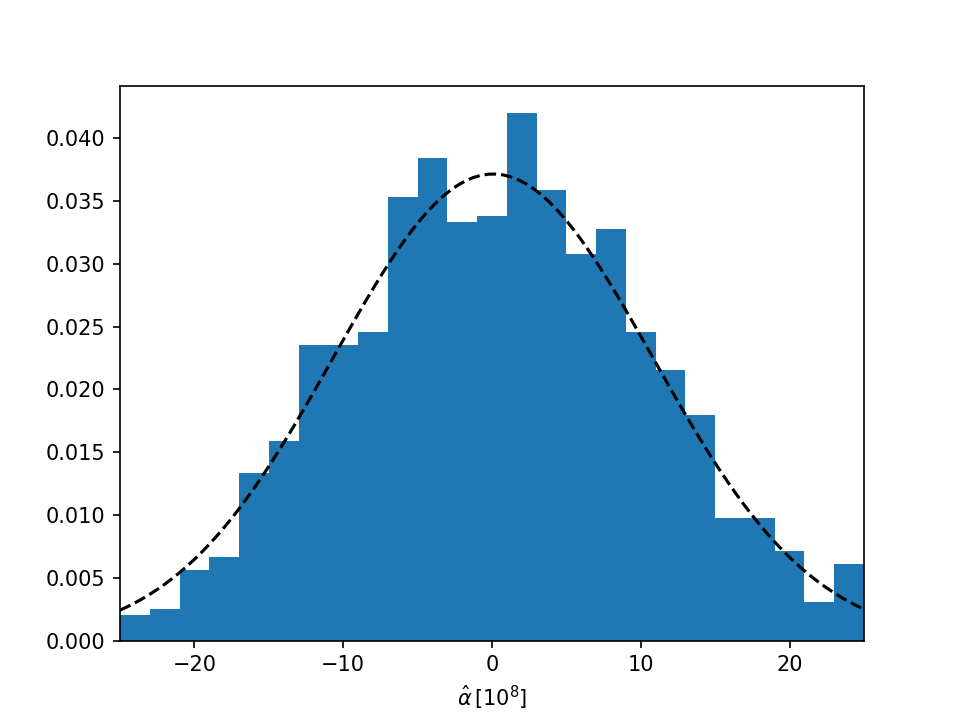

alpha MLE:  0.07165405058444094 std:  0.33967268239438925


In [453]:
_,ax = plt.subplots()
data = list(mm_mle_A13)#+list(mm_mle_A10)
avg = np.mean(data)
var = np.var(data)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(-25,25,100)
pdf_y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

ax.hist(data, range=(-25,25), bins=25, density=True)
# ax.hist(mm_mle_A10, range=(-25,25), bins=30, density=True, alpha=0.4)
# Then we plot :
ax.set(xlim=(-25,25), xlabel=r'$\hat{\alpha} \,[10^{8}]$')
ax.plot(pdf_x,pdf_y,'k--')

print('alpha MLE: ', avg, 'std: ', np.std(data)/np.sqrt(1000))

<IPython.core.display.Javascript object>


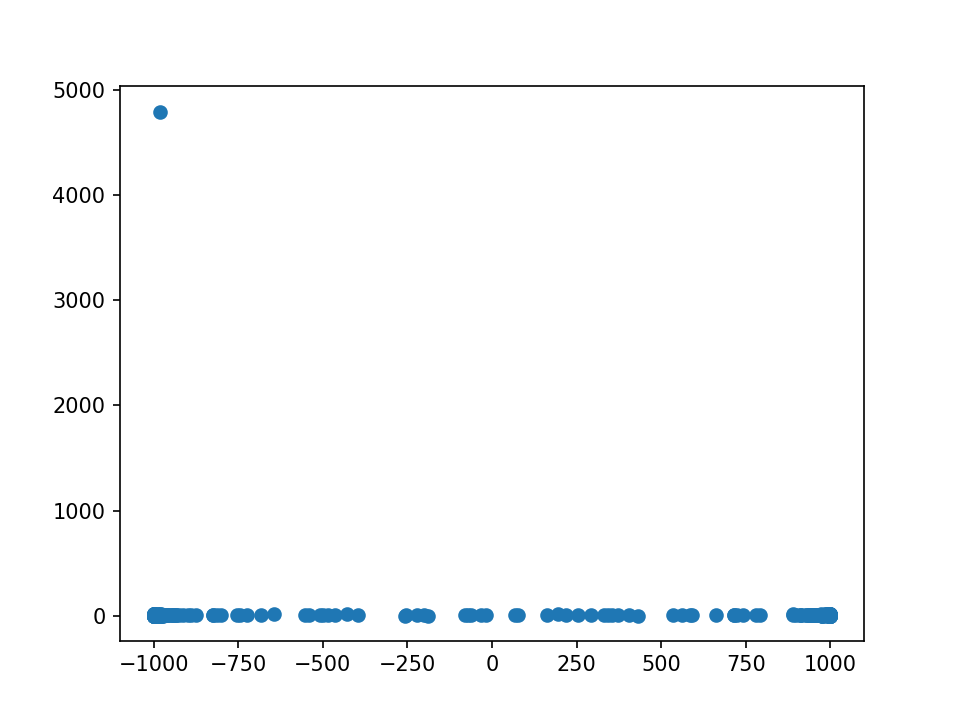

In [222]:
_,ax = plt.subplots()
ax.scatter(mm_mle_A13, mm_mle_A14)